In [11]:
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

from rapidfuzz import fuzz
from pyjarowinkler import distance

from utils.autocomplete.markup_yolo import  get_dates_and_numbers
from utils.autocomplete import yolo_utils as yolo
from utils.operate_data import load_dataset

from transformers import AutoTokenizer, AutoModel, VisionEncoderDecoderModel, TrOCRProcessor
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

In [2]:
model = VisionEncoderDecoderModel.from_pretrained('/local_data/models/microsoft-trocr-base-handwritten-numbers/')
processor = TrOCRProcessor.from_pretrained('/local_data/models/microsoft-trocr-base-handwritten-numbers/processor/')


# tokenizer = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten", 
#                                                       force_download=True, resume_download=False)
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# processor.save_pretrained('/local_data/models/microsoft-trocr-base-handwritten/processor/')

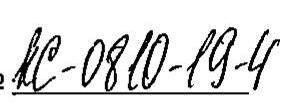

In [3]:
PATH_TO_NUMBERS_IMAGES = Path('/local_data/yolov_markup/handwrites_images/numbers/') # путь к  изображениям дат 
PATH_TO_DETECT_PDF = Path('/data/docs/mer/vh_full/')

image = Image.open(PATH_TO_NUMBERS_IMAGES / '001b25c9-eee1-4b49-b7d5-8c8388596eb0.jpeg').convert("RGB")
image

###  research model microsoft/trocr-base-handwritten

In [4]:
pixel_values = processor(image, return_tensors="pt").pixel_values

In [5]:
generated_ids  = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'КС-0810-19-4'

In [6]:
path_to_numbers = [path for path in PATH_TO_NUMBERS_IMAGES.iterdir()]

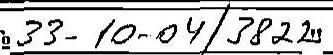

33-10-04/3822 71bb4942-44b2-4761-9d20-013a064698e8


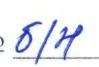

б/н 2db3bc35-2797-4662-8e3f-f111c20ab38b


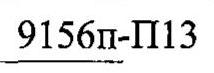

9156п-П13 0053f156-6acf-4006-bb3a-61fa51f941fe


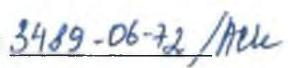

3489-06-72/АСИ decc816b-16d5-4ef5-aa61-daa093966a2e


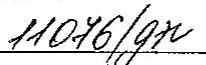

11076/дэс 531ba485-35bf-4674-a429-1d52bb4488c3


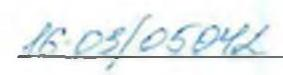

16-03/05042 cf5db2e3-ddd3-43ad-b976-799499d0f82d


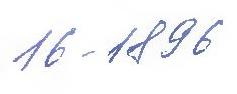

16-1896 64932109-0686-4249-b581-d319693764dc


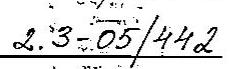

2.3-05/442 ecad474c-7125-4845-81c4-1baf6520474b


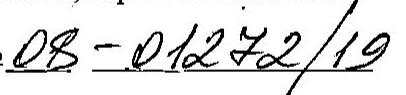

08-01272/19 d1ebe89d-de78-46f7-8982-029ebad1a04d


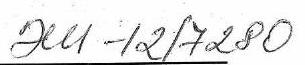

ЭШ-12/7280 b9781ac9-8c5b-4032-8d5f-31cda98a1237


In [7]:
paths = path_to_numbers[:10]
# paths = path_to_dates
numbers, doc_id, images = [], [], []
for path in paths:
    image = Image.open(path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids  = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    display(image)
    numbers.append(generated_text)
    doc_id.append(path.stem)
    images.append(image)
    print(generated_text, path.stem)  

In [8]:
dfs = {'doc_id': doc_id, 'predict_numbers': numbers, 'image': images}
df_no_train = pd.DataFrame(dfs)
df_no_train

,doc_id,predict_numbers,image
0,71bb4942-44b2-4761-9d20-013a064698e8,33-10-04/3822,<PIL.Image.Image image mode=RGB size=333x55 at...
1,2db3bc35-2797-4662-8e3f-f111c20ab38b,б/н,<PIL.Image.Image image mode=RGB size=99x67 at ...
2,0053f156-6acf-4006-bb3a-61fa51f941fe,9156п-П13,<PIL.Image.Image image mode=RGB size=214x73 at...
3,decc816b-16d5-4ef5-aa61-daa093966a2e,3489-06-72/АСИ,<PIL.Image.Image image mode=RGB size=288x68 at...
4,531ba485-35bf-4674-a429-1d52bb4488c3,11076/дэс,<PIL.Image.Image image mode=RGB size=206x65 at...
5,cf5db2e3-ddd3-43ad-b976-799499d0f82d,16-03/05042,<PIL.Image.Image image mode=RGB size=283x75 at...
6,64932109-0686-4249-b581-d319693764dc,16-1896,<PIL.Image.Image image mode=RGB size=237x94 at...
7,ecad474c-7125-4845-81c4-1baf6520474b,2.3-05/442,<PIL.Image.Image image mode=RGB size=230x69 at...
8,d1ebe89d-de78-46f7-8982-029ebad1a04d,08-01272/19,<PIL.Image.Image image mode=RGB size=406x95 at...
9,b9781ac9-8c5b-4032-8d5f-31cda98a1237,ЭШ-12/7280,<PIL.Image.Image image mode=RGB size=305x65 at...


### Create dataframe with images and doc_id

In [9]:
# df_meta = yolo.get_meta(PATH_TO_DETECT_PDF)

In [12]:
df_meta, _ = load_dataset('/local_data/meta_data/', df_name = 'meta.pickle', files_df_name=None)
df_meta.reset_index(inplace=True)

In [13]:
df_meta = df_meta[['doc_id', 'outgoing_number']]

In [14]:
# paths = path_to_dates[:10]
paths = path_to_numbers
doc_id, images = [], []
for path in paths:
    images.append(Image.open(path).convert("RGB"))
    doc_id.append(path.stem)
img = {'doc_id': doc_id, 'image': images}    
df_images = pd.DataFrame(img)


# создание небольшого датафрейма с перемешанными данными
# df_images = df_images.sample(frac=1)
# df_images = df_images.head(200)
df_images

,doc_id,image
0,71bb4942-44b2-4761-9d20-013a064698e8,<PIL.Image.Image image mode=RGB size=333x55 at...
1,2db3bc35-2797-4662-8e3f-f111c20ab38b,<PIL.Image.Image image mode=RGB size=99x67 at ...
2,0053f156-6acf-4006-bb3a-61fa51f941fe,<PIL.Image.Image image mode=RGB size=214x73 at...
3,decc816b-16d5-4ef5-aa61-daa093966a2e,<PIL.Image.Image image mode=RGB size=288x68 at...
4,531ba485-35bf-4674-a429-1d52bb4488c3,<PIL.Image.Image image mode=RGB size=206x65 at...
...,...,...
1989,9742bc0a-e407-4338-9177-21b3ce3f7f54,<PIL.Image.Image image mode=RGB size=413x88 at...
1990,a1ab0661-9042-460e-8399-a91f5d43be3e,<PIL.Image.Image image mode=RGB size=342x76 at...
1991,0feaa227-fc2c-4bab-a204-504a4ddbfcc2,<PIL.Image.Image image mode=RGB size=213x68 at...
1992,e215a19f-ab08-4048-bf1f-67247e1ca117,<PIL.Image.Image image mode=RGB size=403x79 at...


In [15]:
df_images = df_images.merge(df_meta, on='doc_id')
# df_images['outgoing_number'] = df_images['outgoing_number'].apply(lambda row: row.date())

In [16]:
df_images

,doc_id,image,outgoing_number
0,71bb4942-44b2-4761-9d20-013a064698e8,<PIL.Image.Image image mode=RGB size=333x55 at...,33-10-04/3822
1,2db3bc35-2797-4662-8e3f-f111c20ab38b,<PIL.Image.Image image mode=RGB size=99x67 at ...,б/н
2,0053f156-6acf-4006-bb3a-61fa51f941fe,<PIL.Image.Image image mode=RGB size=214x73 at...,9156п-П13
3,decc816b-16d5-4ef5-aa61-daa093966a2e,<PIL.Image.Image image mode=RGB size=288x68 at...,3489-06-72/АСИ
4,531ba485-35bf-4674-a429-1d52bb4488c3,<PIL.Image.Image image mode=RGB size=206x65 at...,11076/дэс
...,...,...,...
1989,9742bc0a-e407-4338-9177-21b3ce3f7f54,<PIL.Image.Image image mode=RGB size=413x88 at...,03-10004-ВА19
1990,a1ab0661-9042-460e-8399-a91f5d43be3e,<PIL.Image.Image image mode=RGB size=342x76 at...,МН-5.8/2249
1991,0feaa227-fc2c-4bab-a204-504a4ddbfcc2,<PIL.Image.Image image mode=RGB size=213x68 at...,И38-1252
1992,e215a19f-ab08-4048-bf1f-67247e1ca117,<PIL.Image.Image image mode=RGB size=403x79 at...,10-09980-ВС/19


### Train model

In [17]:
len(df_images)

1994

In [18]:
train_size = int(len(df_images)*0.85)
test_size = len(df_images) - train_size

train_df = df_images.head(train_size)
test_df = df_images.tail(test_size)

In [19]:
# train_df = df_images[df_images.month == 10]
# test_df = df_images[df_images.month != 10]

In [20]:
train_df.shape, test_df.shape

((1694, 3), (300, 3))

In [91]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

/tmp/ipykernel_571/675210390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)
/tmp/ipykernel_571/675210390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(inplace=True)


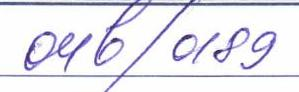

In [92]:
test_df['image'].iloc[0]

In [93]:
class IAMDataset(Dataset):
    def __init__(self,df, processor, max_target_length=32):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        image = self.df['image'].iloc[idx]
        text = self.df['outgoing_number'].iloc[idx]
        # prepare image (i.e. resize + normalize)
#         image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [94]:
train_dataset = IAMDataset(df=train_df, processor=processor)
eval_dataset = IAMDataset(df=test_df, processor=processor)

In [95]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1694
Number of validation examples: 300


In [96]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])


In [97]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

33-10-04/3822


In [98]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 32
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [99]:
# from datasets import load_metric

# cer_metric = load_metric("cer")

In [100]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    
    label_number = ''.join(list(filter(None,label_str)))
    predict_number = ''.join(list(filter(None,pred_str)))


    sim = fuzz.token_sort_ratio(predict_number, label_number)
    
    return {'similarity': round(sim,3)}#, 'predict': predict_date, 'label': label_date}

#     cer = cer_metric.compute(predictions=pred_str, references=label_str)
#     return {"cer": cer}
    

In [119]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False, 
    output_dir="./",
    num_train_epochs=30,
    save_total_limit=3,
#     logging_steps=2,
#     save_steps=1000,
#     eval_steps=200,
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

/opt/venv/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [120]:
trainer.train()

Trainer is attempting to log a value of "{'vocab_size': 50265, 'd_model': 1024, 'decoder_layers': 12, 'decoder_attention_heads': 16, 'decoder_ffn_dim': 4096, 'activation_function': 'gelu', 'max_position_embeddings': 512, 'dropout': 0.1, 'attention_dropout': 0.0, 'activation_dropout': 0.0, 'init_std': 0.02, 'decoder_layerdrop': 0.0, 'use_cache': False, 'scale_embedding': False, 'use_learned_position_embeddings': True, 'layernorm_embedding': True, 'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': True, 'cross_attention_hidden_size': 768, 'add_cross_attention': True, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 

Epoch,Training Loss,Validation Loss,Similarity
1,No log,1.025758,87.879000
2,No log,0.980907,85.905000
3,0.231600,0.948757,89.085000
4,0.231600,0.934832,88.356000
5,0.240100,1.004889,88.480000
6,0.240100,0.973799,87.920000
7,0.240100,0.940933,88.243000
8,0.162000,0.949698,89.067000
9,0.162000,0.949376,89.669000
10,0.135500,1.003063,87.963000


TrainOutput(global_step=6360, training_loss=0.08277743368309999, metrics={'train_runtime': 94124.212, 'train_samples_per_second': 0.54, 'train_steps_per_second': 0.068, 'total_flos': 3.802785340641509e+19, 'train_loss': 0.08277743368309999, 'epoch': 30.0})

In [108]:
model.save_pretrained('/local_data/models/microsoft-trocr-base-handwritten-numbers/')

In [109]:
processor.save_pretrained('/local_data/models/microsoft-trocr-base-handwritten-numbers/processor/')

# predict

In [21]:
def predict_number(image, processor, model):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids  = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return generated_text

In [22]:
test_df['predict_number'] = test_df.image.progress_apply(lambda row: predict_number(row, processor, model))
test_df['sim'] = test_df.apply(lambda row: fuzz.token_sort_ratio(row['outgoing_number'], row['predict_number']), axis=1)

test_df['target'] = test_df['predict_number'] == test_df['outgoing_number']

100%|██████████| 300/300 [11:49<00:00,  2.37s/it]
/tmp/ipykernel_267/1034399493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predict_number'] = test_df.image.progress_apply(lambda row: predict_number(row, processor, model))
/tmp/ipykernel_267/1034399493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sim'] = test_df.apply(lambda row: fuzz.token_sort_ratio(row['outgoing_number'], row['predict_number']), axis=1)
/tmp/ipykernel_267/1034399493.py:4: SettingWithCopyWarning: 
A value 

In [23]:
test_df.target.value_counts()

target
True     169
False    131
Name: count, dtype: int64

In [24]:
len(test_df[test_df.sim >= 90])/len(test_df)

0.7566666666666667

In [25]:
len(test_df[test_df.sim == 100])/len(test_df)

0.5633333333333334

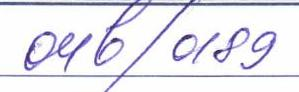

In [32]:
x = 1694
test_df.loc[x].image

In [33]:
 test_df.loc[x].predict_number

'04в/0189'

In [117]:
test_df

,doc_id,image,outgoing_number,predict_number,sim,target
1694,07f63e53-ca49-48e2-92af-d1586223452e,<PIL.Image.Image image mode=RGB size=299x92 at...,04в/0189,04в/0189,100.000000,True
1695,84882a14-3ab7-4393-b780-8e371086d0d3,<PIL.Image.Image image mode=RGB size=275x98 at...,КЭ/1200/408,47/1200/408,81.818182,False
1696,3af3a7fc-8614-4ae7-b25a-bd03674f8b70,<PIL.Image.Image image mode=RGB size=200x71 at...,11284/дэс,11284/дэс,100.000000,True
1697,ef075d68-dd35-4f29-b2d0-d5a518672db6,<PIL.Image.Image image mode=RGB size=289x81 at...,43-5291-5,43-52941-5,94.736842,False
1698,13d0fb7d-5488-4720-a84b-a8a860b27cf8,<PIL.Image.Image image mode=RGB size=393x69 at...,и-кми-09/16665,и-тш-09/16600,66.666667,False
...,...,...,...,...,...,...
1989,9742bc0a-e407-4338-9177-21b3ce3f7f54,<PIL.Image.Image image mode=RGB size=413x88 at...,03-10004-ВА19,03-10004-ВА/19,96.296296,False
1990,a1ab0661-9042-460e-8399-a91f5d43be3e,<PIL.Image.Image image mode=RGB size=342x76 at...,МН-5.8/2249,МН-5.2249,90.000000,False
1991,0feaa227-fc2c-4bab-a204-504a4ddbfcc2,<PIL.Image.Image image mode=RGB size=213x68 at...,И38-1252,И38-1252,100.000000,True
1992,e215a19f-ab08-4048-bf1f-67247e1ca117,<PIL.Image.Image image mode=RGB size=403x79 at...,10-09980-ВС/19,10-09980-ВС/19,100.000000,True


In [52]:
token = processor(image, return_tensors="pt").pixel_values

In [45]:
train_dataset[1]['pixel_values']

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7176, 0.7882, 0.8275],
         [1.0000, 1.0000, 1.0000,  ..., 0.7176, 0.7882, 0.8275],
         [1.0000, 1.0000, 1.0000,  ..., 0.7176, 0.7882, 0.8275],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 0.9843]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.7725, 0.8431, 0.8824],
         [1.0000, 1.0000, 1.0000,  ..., 0.7725, 0.8431, 0.8824],
         [1.0000, 1.0000, 1.0000,  ..., 0.7725, 0.8431, 0.8824],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 0.9843]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8353, 0.9059, 0.9451],
         [1.0000, 1.0000, 1.0000,  ..., 0.8353, 0.9059, 0.9451],
         [1.0000, 1.0000, 1.0000,  ..., 0.8353, 0.9059, 0.

In [ ]:
pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)

In [34]:
labels_ids = train_dataset[1]['labels']

In [35]:
labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
# label_str = processor.decode(labels_ids, skip_special_tokens=True)
label_str = processor.batch_decode(labels, skip_special_tokens=True)
label_str

['',
 '02',
 '.',
 '10',
 '.',
 '2019',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [39]:
len(label_str)

32

In [36]:
''.join(list(filter(None,label_str)))

'02.10.2019'

In [37]:
labels_ids

tensor([    0,  4197,     4,   698,     4, 10626,     2,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1])

In [38]:
label_str

['',
 '02',
 '.',
 '10',
 '.',
 '2019',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [43]:
text = '20.12.2023'
p1 = '20.12.2023'
p2 = '20 12 2023'
p3 = '12 21 2923'
p4 = '11 2145'
p5 = ' 11 сентября 2023 года.'
lst = [p1, p2, p3, p4, p5]

In [44]:
for idx in lst:
    f = fuzz.token_sort_ratio(text, idx)
    d = distance.get_jaro_distance(text.lower(), idx.lower(), winkler=True, scaling=0.1) * 100
    print(f'date: {idx}, fuzz: {f}, jaro: {d}\n')

date: 20.12.2023, fuzz: 100.0, jaro: 100.0

date: 20 12 2023, fuzz: 60.0, jaro: 89.0

date: 12 21 2923, fuzz: 50.0, jaro: 68.0

date: 11 2145, fuzz: 23.529411764705888, jaro: 33.0

date:  11 сентября 2023 года., fuzz: 31.25, jaro: 43.0



In [45]:
for idx in lst:
    print(len(idx))

10
10
10
7
23


In [ ]:
# tokenizer = VisionEncoderDecoderModel.from_pretrained("DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition_v2")
# model = VisionEncoderDecoderModel.from_pretrained("DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition_v2")

# tokenizer = VisionEncoderDecoderModel.from_pretrained("jinhybr/OCR-Donut-CORD")
# model = VisionEncoderDecoderModel.from_pretrained("jinhybr/OCR-Donut-CORD")

# tokenizer = AutoTokenizer.from_pretrained("DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr")
# model = VisionEncoderDecoderModel.from_pretrained("DunnBC22/trocr-large-printed-cmc7_tesseract_MICR_ocr")